# Preprocessing CppSATD Dataset

Notebook này thực hiện tiền xử lý dữ liệu từ file `manual_annotations.csv`, đặc biệt là cột `commenttext` — vốn chứa các comment C/C++ với nhiều ký hiệu `//`, `/*`, `*/`, `/**`, `//!` và xuống dòng không đồng nhất.

## 1. Import thư viện & Load dữ liệu

In [1]:
import pandas as pd
import re
import os

DATA_PATH = os.path.join(
    "..", "data", "data_and_scripts", "data_and_scripts", "manual_annotations.csv"
)

df = pd.read_csv(DATA_PATH)
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
df.head(3)

Shape: (35098, 7)
Columns: ['comment_id', 'commenttext', 'preceding_code', 'succeeding_code', 'file_id', 'projectname', 'manual_annotation']


,comment_id,commenttext,preceding_code,succeeding_code,file_id,projectname,manual_annotation
0,21897,// If no suitable candidate from the same peer...,NaN,\n const auto cpfp_candidates_different_pee...,835.cpp,bitcoin,NON-SATD
1,302,//! Utility function to add all of a transacti...,NaN,"\nvoid AddCoins(CCoinsViewCache& cache, const ...",1023.h,bitcoin,REQUIREMENT
2,811,"/** Work around circular dependency, as well a...",NaN,\nconst std::vector<unsigned char>& GetObfusca...,1041.h,bitcoin,DESIGN/CODE


## 2. Khám phá sơ bộ cột `commenttext`

In [2]:
# Số lượng null
print("Null values:")
print(df['commenttext'].isna().sum())

# Một vài ví dụ thực tế
print("\n--- Ví dụ comment trước khi clean ---")
for i, row in df.sample(5, random_state=42).iterrows():
    print(f"[{i}] {repr(row['commenttext'][:200])}")
    print()

Null values:
0

--- Ví dụ comment trước khi clean ---
[9904] '// TODO(allenl): This will block until async execution is complete, which\n// will be slow. We should find a non-blocking way of fetching the shape,\n// at least pre-cache.\n// The shape passed into MLIR'

[70] '// ugly hack: for some unknown reason CAmount (instead of qint64) does not work here as expected\n// discussion: https://github.com/bitcoin/bitcoin/pull/5117'

[8170] '// TODO: b/323943471 - This macro should eventually be provided by Abseil.'

[29325] '// Note(nikhilsarda): This heuristic is optimal in benchmarks as of\n// Jan 21, 2020.'

[4949] '// Register constraint restrictions.\n// FIXME: Copy these directly into some kind of partial solution?'



## 3. Hàm làm sạch `commenttext`

Các bước thực hiện:
1. Xử lý `NaN` → chuỗi rỗng
2. Loại bỏ ký hiệu mở/đóng block comment (`/**`, `/*`, `*/`, `*`)
3. Loại bỏ prefix `//!` và `//` ở đầu mỗi dòng
4. Loại bỏ khoảng trắng thừa đầu/cuối mỗi dòng
5. Loại bỏ dòng trống liên tiếp
6. Ghép lại thành một chuỗi duy nhất (chuẩn hoá newline)

In [3]:
def clean_comment(text: str) -> str:
    """Làm sạch một comment C/C++ thành văn bản thuần."""
    if not isinstance(text, str):
        return ""

    # 1. Chuẩn hoá newline (Windows \r\n → \n)
    text = text.replace("\r\n", "\n").replace("\r", "\n")

    # 2. Xử lý từng dòng
    lines = text.split("\n")
    cleaned_lines = []
    for line in lines:
        # Xoá khoảng trắng đầu dòng trước khi kiểm tra prefix
        stripped = line.strip()

        # Loại bỏ dấu mở block comment đứng một mình: /**, /*, hoặc /**< ...
        stripped = re.sub(r'^/\*+<?\s*', '', stripped)

        # Loại bỏ dấu đóng block comment: */ hoặc dấu * ở đầu dòng trong block
        stripped = re.sub(r'^\*+/?\s*', '', stripped)

        # Loại bỏ prefix //! và // (kể cả ///<, ///)
        stripped = re.sub(r'^/{2,}[!<]?', '', stripped)

        # Xoá khoảng trắng thừa đầu/cuối
        stripped = stripped.strip()

        cleaned_lines.append(stripped)

    # 3. Loại bỏ các dòng trống liên tiếp (chỉ giữ tối đa 1 dòng trống)
    merged = []
    prev_empty = False
    for line in cleaned_lines:
        if line == "":
            if not prev_empty:
                merged.append(line)
            prev_empty = True
        else:
            merged.append(line)
            prev_empty = False

    # 4. Xoá dòng trống ở đầu và cuối
    while merged and merged[0] == "":
        merged.pop(0)
    while merged and merged[-1] == "":
        merged.pop()

    return "\n".join(merged)


# Kiểm tra nhanh
sample = df['commenttext'].dropna().iloc[0]
print("--- BEFORE ---")
print(sample)
print("\n--- AFTER ---")
print(clean_comment(sample))

--- BEFORE ---
// If no suitable candidate from the same peer is found, also try children that were provided by
// a different peer. This is useful because sometimes multiple peers announce both transactions
// to us, and we happen to download them from different peers (we wouldn't have known that these
// 2 transactions are related). We still want to find 1p1c packages then.
//
// If we start tracking all announcers of orphans, we can restrict this logic to parent + child
// pairs in which both were provided by the same peer, i.e. delete this step.

--- AFTER ---
If no suitable candidate from the same peer is found, also try children that were provided by
a different peer. This is useful because sometimes multiple peers announce both transactions
to us, and we happen to download them from different peers (we wouldn't have known that these
2 transactions are related). We still want to find 1p1c packages then.

If we start tracking all announcers of orphans, we can restrict this logic t

## 4. Áp dụng làm sạch & kiểm tra kết quả

In [4]:
df['commenttext_clean'] = df['commenttext'].apply(clean_comment)

# So sánh trước/sau với random samples
print("=" * 60)
for i, row in df.sample(8, random_state=0).iterrows():
    print(f"--- Row {i} ---")
    print("BEFORE:", repr(row['commenttext'][:300]))
    print("AFTER: ", repr(row['commenttext_clean'][:300]))
    print()

--- Row 32404 ---
BEFORE: '/// Convert the TFLite buffers field between LE and BE format in a\n/// FlatBufferModel which is not empty and return the converted instance.'
AFTER:  'Convert the TFLite buffers field between LE and BE format in a\nFlatBufferModel which is not empty and return the converted instance.'

--- Row 12756 ---
BEFORE: '// Either no ring order was passed in, or the format was unexpected.\n// We now assign a ring order based on link strengths.  Note that this\n// algorithm is not optimal and may not always find the best ring order.'
AFTER:  'Either no ring order was passed in, or the format was unexpected.\nWe now assign a ring order based on link strengths.  Note that this\nalgorithm is not optimal and may not always find the best ring order.'

--- Row 22290 ---
BEFORE: '// Skip functions with no partial application uses.'
AFTER:  'Skip functions with no partial application uses.'

--- Row 32546 ---
BEFORE: '// namespace facebook::react'
AFTER:  'namespace facebook:

## 5. Thống kê độ dài trước và sau khi làm sạch

       len_before  len_after  len_reduction_pct
count    35098.00   35098.00           35098.00
mean       182.49     164.05               9.08
std        488.09     436.43               8.50
min          3.00       0.00               0.40
25%         41.00      37.00               4.90
50%         77.00      72.00               6.20
75%        173.00     161.00               9.70
max      32767.00   32619.00             100.00


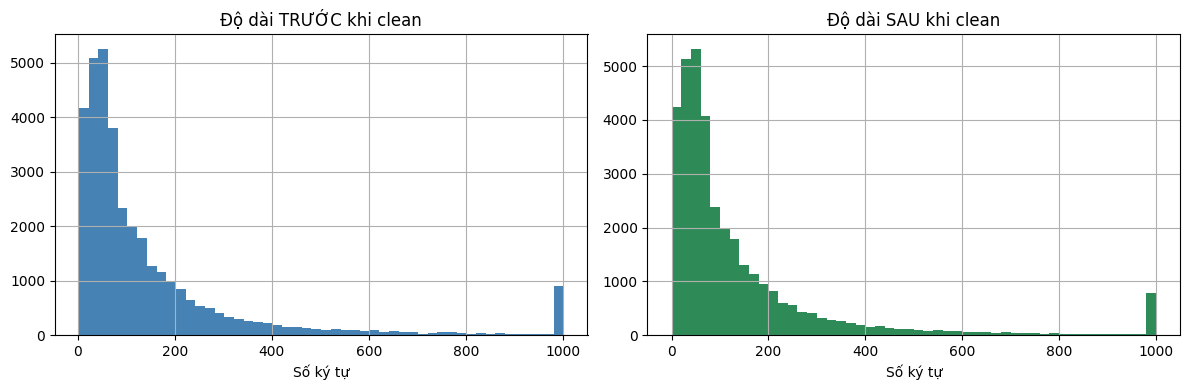

In [5]:
import matplotlib.pyplot as plt

df['len_before'] = df['commenttext'].fillna('').apply(len)
df['len_after'] = df['commenttext_clean'].apply(len)
df['len_reduction_pct'] = ((df['len_before'] - df['len_after']) / df['len_before'].replace(0, 1) * 100).round(1)

print(df[['len_before', 'len_after', 'len_reduction_pct']].describe().round(2))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
df['len_before'].clip(upper=1000).hist(bins=50, ax=axes[0], color='steelblue')
axes[0].set_title('Độ dài TRƯỚC khi clean')
axes[0].set_xlabel('Số ký tự')

df['len_after'].clip(upper=1000).hist(bins=50, ax=axes[1], color='seagreen')
axes[1].set_title('Độ dài SAU khi clean')
axes[1].set_xlabel('Số ký tự')

plt.tight_layout()
plt.show()

## 6. Kiểm tra các comment rỗng sau khi làm sạch

In [6]:
empty_after = df[df['commenttext_clean'].str.strip() == '']
print(f"Số comment rỗng sau khi clean: {len(empty_after)}")
if len(empty_after) > 0:
    print("\nCác comment gốc:")
    for i, row in empty_after.head(10).iterrows():
        print(f"  [{i}] {repr(row['commenttext'])}")

Số comment rỗng sau khi clean: 25

Các comment gốc:
  [20033] '/////'
  [20843] '/////////////////////////////////////////////////////////////////////////////////\n//'
  [21349] '/* */'
  [21388] '//////////////'
  [22491] '//////////////////'
  [22690] '///////////////////////////////////////////////'
  [22980] '////////////////////////////////\n/////////////////////////////////////'
  [23866] '///////////////////////////////////////////////////////////////////\n////////'
  [23982] '///////////////////////////////////////////////////////////////\n/////////////////'
  [24740] '//!'


## 7. (Tuỳ chọn) Chuẩn hoá thêm: lowercase & loại bỏ ký tự đặc biệt

Bước này hữu ích nếu dùng cho các mô hình ML không phân biệt hoa/thường.

In [7]:
def normalize_text(text: str) -> str:
    """Lowercase + loại bỏ ký tự không phải chữ/số/khoảng trắng."""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    # Giữ lại chữ, số, khoảng trắng và dấu câu cơ bản
    text = re.sub(r'[^\w\s\.,;:\-\(\)\[\]\#\"\'\/\%\=\+\!\?]', ' ', text)
    # Chuẩn hoá khoảng trắng thừa
    text = re.sub(r'[ \t]+', ' ', text)
    text = re.sub(r'\n{2,}', '\n', text)
    return text.strip()


df['commenttext_normalized'] = df['commenttext_clean'].apply(normalize_text)

# Xem thử
for i, row in df.sample(3, random_state=7).iterrows():
    print(f"--- Row {i} ---")
    print("CLEAN:     ", repr(row['commenttext_clean'][:200]))
    print("NORMALIZED:", repr(row['commenttext_normalized'][:200]))
    print()

--- Row 4664 ---
CLEAN:      'Dominating ownershipDef example: handleReborrow must continue visiting phi\nuses:\n\nbb0:\nd1 = ...\ncond_br bb1, bb2\nbb1:\nb1 = borrow d1\nbr bb3(b1)\nbb2:\nb2 = borrow d1\nbr bb3(b2)\nbb3(reborrow):\nu1 = d1\nu2'
NORMALIZED: 'dominating ownershipdef example: handlereborrow must continue visiting phi\nuses:\nbb0:\nd1 = ...\ncond_br bb1, bb2\nbb1:\nb1 = borrow d1\nbr bb3(b1)\nbb2:\nb2 = borrow d1\nbr bb3(b2)\nbb3(reborrow):\nu1 = d1\nu2 '

--- Row 10115 ---
CLEAN:      'TODO(toddw): Invoke shape inference in AddPlaceholdersForFeeds and add a\n"_shape" attr if we can determine it.  That way the graph will be\ninitialized with whatever shapes we can infer, while the user'
NORMALIZED: 'todo(toddw): invoke shape inference in addplaceholdersforfeeds and add a\n"_shape" attr if we can determine it. that way the graph will be\ninitialized with whatever shapes we can infer, while the user '

--- Row 4424 ---
CLEAN:      'TODO'
NORMALIZED: 'todo'



## 8. Lưu dữ liệu đã xử lý

In [8]:
OUTPUT_PATH = os.path.join(
    "..", "data", "data_and_scripts", "data_and_scripts", "manual_annotations_cleaned.csv"
)

# Chọn các cột cần lưu
cols_to_save = [
    'comment_id', 'commenttext', 'commenttext_clean', 'commenttext_normalized',
    'preceding_code', 'succeeding_code', 'file_id', 'projectname', 'manual_annotation'
]
df[cols_to_save].to_csv(OUTPUT_PATH, index=False)
print(f"Đã lưu file: {OUTPUT_PATH}")
print(f"Shape: {df[cols_to_save].shape}")
df[['comment_id', 'commenttext_clean', 'manual_annotation']].head(5)

Đã lưu file: ..\data\data_and_scripts\data_and_scripts\manual_annotations_cleaned.csv
Shape: (35098, 9)


,comment_id,commenttext_clean,manual_annotation
0,21897,If no suitable candidate from the same peer is...,NON-SATD
1,302,Utility function to add all of a transaction's...,REQUIREMENT
2,811,"Work around circular dependency, as well as fo...",DESIGN/CODE
3,1830,TODO(sanjay): Merge with existing error?,DESIGN/CODE
4,2709,TODO(sanjay): Suppress dups?,DESIGN/CODE
